# CS-141 Homework 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.patches import Ellipse

%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [2]:
def plot_ellipse(cov, center, t):
    """ 
    Plot an ellipse based on a covariance matrix in matplotlib
    Inputs: covariance matrix, center
    Outputs: plotted ellipse
    """
    eig_vals, eig_vect = np.linalg.eig(cov)
    # print("\n Eigenvalues \n",eig_vals)
    # print("\n Eigenvectors \n",eig_vect)

    # lamdax = eig_vals[0]
    # lamday = eig_vals[1]

    # Get smallest and largest eigenvectors/values
    max_ind = np.argmax(eig_vals) # USE ABSOLUTE VALUE?
    # print("\n Max eig value indice =", max_ind)
    max_EV = eig_vect[:,max_ind]
    max_eval = np.max(eig_vals)
    min_eval = np.min(eig_vals)

    # Do we need these ??
    lamdax = eig_vals[0]
    lamday = eig_vals[1]

    if max_ind == 0:
        min_EV = eig_vect[:,1]
    else:
        min_EV = eig_vect[:,0]
    
    # print("\n Max eig vector = ", max_EV)
    # print("\n Min eig vector = ", min_EV)
    # print("\n Max eig val = ", max_eval)
    # print("\n Min eig val = ", min_eval)
    
    # Major and minor axes
    maj_len = 2*np.sqrt(lamdax)
    min_len = 2*np.sqrt(lamday)
    
    # Angle between x-axis and largest eigenvector
    angle = np.arctan2(max_EV[1], max_EV[0])
    if angle < 0: angle += 2*np.pi
    # print("\n Angle between x-axis and largest EV = ", angle)

    # Mean data coords
    center = center
    chi_sq = 1

    a = chi_sq * np.sqrt(max_eval)
    b = chi_sq * np.sqrt(min_eval)
    theta = np.linspace(0, 2*np.pi, 1000);
    pts_x = np.array(a * np.cos(theta))
    pts_y = np.array(b * np.sin(theta))
    pts_tot = np.vstack([pts_x, pts_y])
    # print(pts_tot)
    pts_tot = pts_tot.T

    # Rotation matrix 
    R = [[np.cos(angle), np.sin(angle)],[-np.sin(angle), np.cos(angle)]]
    # print(R)
    r_ellipse = pts_tot @ R
    # print(r_ellipse)

    plt.plot(r_ellipse[:,0] + center[0], r_ellipse[:,1] + center[1], label = t)

    # Define the ellipse
    # ellipse = Ellipse(center, r_ellipse[:,0], r_ellipse[:,1], angle=angle, edgecolor='blue', facecolor='none')
    # ax.add_patch(ellipse)

    return ax

In [3]:
def kalman_filter_pred(A, B, R, state_prev, post_prev):
    """ Simulates Kalman filter prediction steps: ALGORITHM LINES 2-3
    Assumptions: deltaT = 1, system starts at REST, acceleration N~(0,1)
    Input: A, B, R matrices, previous state and posterior
    Output: predicted states, covariance, and acceleration for current state
    """

    # Random sample acceleration
    u_t = np.random.normal(0, 1, size=(1,1))
    acc = u_t.item()

    # State prediction 
    state_new_p = A @ state_prev + B @ u_t

    # Posterior 
    post_new_p = A @ post_prev @ A.T + R

    return state_new_p, post_new_p, acc

In [4]:
def kalman_filter_prob2_2_GPS(A, B, C, Q, R, state_prev, post_prev, t):
    """ ONLY FOR PROBLEM 2.2: ASKS FOR A MEASUREMENT OF 10 at TIME T=5
    Simulates Kalman filter prediction and measurement update steps: ALGORITHM LINES 2-6
    Assumptions: deltaT = 1, system starts at REST, acceleration N~(0,1)
    Input: A, B, C, Q, R matrices, previous state and posterior, GPS sensor probability
    Output: updated state prediction, covariance, and acceleration for current state
    """

    # PREDICTION STEPS: LINES 2-3
    # Random sample for accel using normal dist
    u_t = np.random.normal(0, 1, size=(1,1))
    acc = u_t.item()
    
    # State prediction 
    state_new_p = A @ state_prev + B @ u_t

    # Posterior 
    post_new_p = A @ post_prev @ A.T + R

    # MEASURMENT UPDATE STEPS: LINES 4-6
    # Only happens at time t = 5
    if t == 5:
        print("\n State prediction before measurement at t=5 \n", state_new_p, "\n")
        # print("\n Posterior before measurement \n", post_new_p)
        # Sample TRUE POSITION - 10 in this case
        z_t = np.array([[10]])
        print("\n Sensor reading = ", z_t, "\n")
        
        # Kalman gain 
        K_t = post_new_p @ C.T @ np.linalg.inv(C @ post_new_p @ C.T + Q) 
        # print("\n Kalman gain \n",K_t)

        # State update
        # print("\n checkpoint1 = ", z_t - C @ state_new_p)
        # print("\n checkpoint2 = ", K_t@(z_t - C @ state_new_p))
        state_new = state_new_p + K_t @ (z_t - C @ state_new_p)
        print("\n New state \n", state_new)

        # Covariance update 
        post_new = (np.eye(2) - K_t @ C) @ post_new_p
        # print("\n New posterior \n", post_new)
    else:
        # Add state prediction and posterior 
        state_new = state_new_p
        post_new = post_new_p


    return state_new, post_new, acc

In [5]:
def kalman_filter_randGPS(A, B, C, Q, R, state_prev, post_prev, GPS_prob):
    """ Simulates Kalman filter prediction and measurement update steps: ALGORITHM LINES 2-6
    Assumptions: deltaT = 1, system starts at REST, acceleration N~(0,1)
    Input: A, B, C, Q, R matrices, previous state and posterior, GPS sensor probability
    Output: updated state prediction, covariance, and acceleration for current state
    """

    # PREDICTION STEPS: LINES 2-3
    # Random sample for accel using normal dist
    u_t = np.random.normal(0, 1, size=(1,1))
    acc = u_t.item()
    
    # State prediction 
    state_new_p = A @ state_prev + B @ u_t

    # Posterior 
    post_new_p = A @ post_prev @ A.T + R

    # MEASURMENT UPDATE STEPS: LINES 4-6
    # First - if the GPS sensor 'works', get a measurement
    GPS_result = np.random.choice([True, False], p=[GPS_prob, 1-GPS_prob])
    # print(result)

    if GPS_result == True:
        print("\n State prediction before measurement \n", state_new_p, "\n")
        # print("\n Posterior before measurement \n", post_new_p)
        # Sample TRUE POSITION
        pos = np.array([[state_new_p[0,0]]])
        z_t = np.random.normal(pos, sigma_pos, size=(1,1))
        print("\n Sensor reading = ", z_t, "\n")
        
        # Kalman gain 
        K_t = post_new_p @ C.T @ np.linalg.inv(C @ post_new_p @ C.T + Q) 
        # print("\n Kalman gain \n",K_t)

        # State update
        # print("\n checkpoint1 = ", z_t - C @ state_new_p)
        # print("\n checkpoint2 = ", K_t@(z_t - C @ state_new_p))
        state_new = state_new_p + K_t @ (z_t - C @ state_new_p)
        print("\n New state \n", state_new)

        # Covariance update 
        post_new = (np.eye(2) - K_t @ C) @ post_new_p
        # print("\n New posterior \n", post_new)
    else:
        # Add state prediction and posterior 
        state_new = state_new_p
        post_new = post_new_p


    return state_new, post_new, acc, GPS_result

# Part 1: Prediction


 States from t=0 to t=5 
 [[ 0.         -0.30286615 -1.13749943 -1.11301725  1.19539459  5.05729486]
 [ 0.         -0.60573231 -1.06353425  1.11249862  3.50432506  4.21947546]]

 Posterior over x and x_dot 
 [[ 0.    0.    0.25  0.5   2.5   2.    8.75  4.5  21.    8.   41.25 12.5 ]
 [ 0.    0.    0.5   1.    2.    2.    4.5   3.    8.    4.   12.5   5.  ]]

 Accelerations t=0 to t=5 
 [0, -0.6057323092423343, -0.45780193837717514, 2.1760328683363444, 2.391826439440232, 0.7151504035307391]


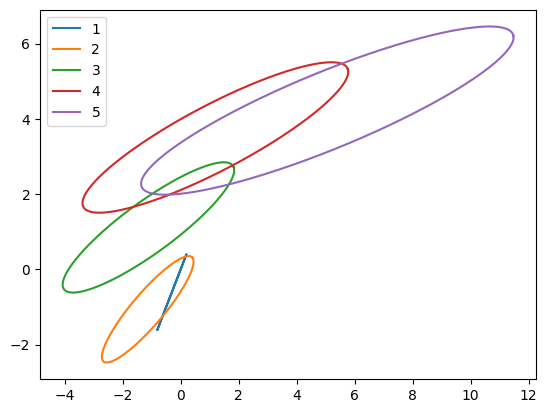

In [6]:
# Question 1.3: Implement state prediction step of Kalman filter

# Assume at t=0, pos, vel, and accel = 0
# Calculate state disrtibution for times t = 1,2,...,5

# Time settings
dt = 1 # Assume delta t is 1 second
t_total = 5 # Total time in seconds
t_steps = int(t_total/dt) # Time steps 

muh_a = 0 # avg accel
sigma_a = 1 

# State transition, linear matrices A and B
A = np.array([[1, dt], [0, 1]])
B = np.array([[.5*dt**2], [dt]])
R = sigma_a * np.array([[.25, .5],[.5, 1]])

# Initialize resting state 
x_0 = np.array([[0],[0]])
cov_0 = np.array([[0, 0],[0, 0]])

# Create a state vector for number of time steps t
states = [x_0]
posts = [cov_0]
accs = [0]

# Create a plot to display axes
plt.figure()
ax = plt.gca()

# For times t=1,2, ..., 5
for i in range(1,t_steps+1):
    # Previous states
    state_prev = states[-1]
    post_prev = posts[-1]
    
    # Generate state prediction and distribution using Kalman algorithm 
    state_new_p, post_new_p, acc = kalman_filter_pred(A, B, R, state_prev, post_prev)

    # Plot an ellipse representing covariance 
    ax = plot_ellipse(post_new_p, state_new_p, i)
    
    # Add state prediction, posterior, and accel
    states.append(state_new_p)
    posts.append(post_new_p)
    accs.append(acc)

states = np.hstack(states)
posts = np.hstack(posts)

print("\n States from t=0 to t=5 \n",states)
print("\n Posterior over x and x_dot \n",posts)
print("\n Accelerations t=0 to t=5 \n",accs)

plt.legend(loc="upper left")
plt.show()

# Part 2: Measurement

## Question 2.2


 State prediction before measurement at t=5 
 [[-1.39125905]
 [-0.67378233]] 


 Sensor reading =  [[10]] 


 New state 
 [[8.1496432 ]
 [2.21740017]]

 States from t=0 to t=5 
 [[ 0.          0.49575272  0.36717108 -0.15051982 -0.54912213  8.1496432 ]
 [ 0.          0.99150544 -1.24866871  0.2132869  -1.01049151  2.21740017]]

 Posterior over x and x_dot 
 [[ 0.          0.          0.25        0.5         2.5         2.
   8.75        4.5        21.          8.          6.70050761  2.03045685]
 [ 0.          0.          0.5         1.          2.          2.
   4.5         3.          8.          4.          2.03045685  1.82741117]]

 Accelerations t=0 to t=5 
 [0, 0.9915054360394883, -2.240174146546468, 1.4619556134539575, -1.223778416485922, 0.3367091798136313]


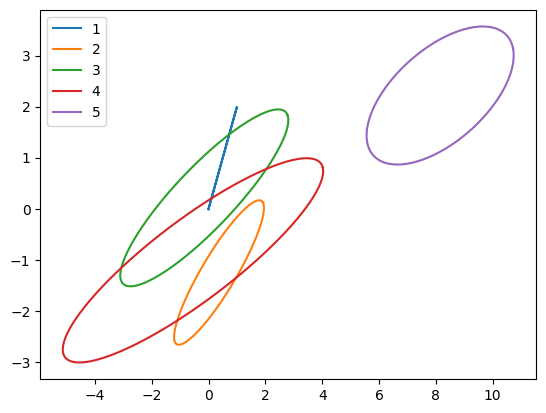

In [7]:
# Implement measurement update 

# Time settings
dt = 1 # Assume delta t is 1 second
t_total = 5 # Total time in seconds
t_steps = int(t_total/dt) # Time steps 

# Initialize resting state 
x_0 = np.array([[0],[0]])
cov_0 = ([0, 0],[0, 0])

# Create a state vector for number of time steps t
states = [x_0]
posts = [cov_0]
accs = [0]
GPS_results = []

muh_a = 0 # avg accel
sigma_a = 1 
sigma_pos = 8

# State transition 
# Linear matrices A and B
A = np.array([[1, dt], [0, 1]])
B = np.array([[.5*dt**2], [dt]])

# Implement C and Q matrices 
C = np.array([[1, 0]])
Q = np.array([[8]])

R = sigma_a * np.array([[.25, .5],[.5, 1]])
# print(R)

# Create plot
plt.figure()
ax = plt.gca()

for i in range(1, t_steps+1):

    # Initialize previous state
    state_prev = states[-1]
    post_prev = posts[-1]

    state_new, post_new, acc = kalman_filter_prob2_2_GPS(A, B, C, Q, R, state_prev, post_prev, i)
    
    # Add state prediction, posterior, accel, and GPS result
    states.append(state_new)
    posts.append(post_new)
    accs.append(acc)

    # Create a covariance ellipse
    ax = plot_ellipse(post_new, state_new, i)


states = np.hstack(states)
posts = np.hstack(posts)

print("\n States from t=0 to t=5 \n",states)
print("\n Posterior over x and x_dot \n",posts)
print("\n Accelerations t=0 to t=5 \n",accs)


plt.legend(loc="upper left")
plt.show()

## Question 2.3

In [8]:
# Implement measurement update 

# GPS SENSOR PROBABILITY 
sensor_prob = 0.9 # 0.1, 0.5, OR 0.9 

# Time settings
dt = 1 # Assume delta t is 1 second
t_total = 20 # Total time in seconds
t_steps = int(t_total/dt) # Time steps 

# Initialize resting state 
x_0 = np.array([[0],[0]])
cov_0 = ([0, 0],[0, 0])

# Create a state vector for number of time steps t
states = [x_0]
posts = [cov_0]
accs = [0]
GPS_results = []

muh_a = 0 # avg accel
sigma_a = 1 
sigma_pos = 8

# State transition 
# Linear matrices A and B
A = np.array([[1, dt], [0, 1]])
B = np.array([[.5*dt**2], [dt]])

# Implement C and Q matrices 
C = np.array([[1, 0]])
Q = np.array([[8]])

R = sigma_a * np.array([[.25, .5],[.5, 1]])
# print(R)

# # Create plot
# plt.figure()
# ax = plt.gca()

# Run N simulations for each scenario 
N = 50

for i in range(1, t_steps+1):

    # Initialize previous state
    state_prev = states[-1]
    post_prev = posts[-1]

    state_new, post_new, acc, GPS_result = kalman_filter_randGPS(A, B, C, Q, R, state_prev, post_prev, sensor_prob)
    
    # Add state prediction, posterior, accel, and GPS result
    states.append(state_new)
    posts.append(post_new)
    accs.append(acc)
    GPS_results.append(GPS_result)

    # # Create a covariance ellipse
    # ax = plot_ellipse(post_new, state_new, i)


states = np.hstack(states)
posts = np.hstack(posts)

print("\n States from t=0 to t=20 \n",states)
print("\n Posterior over x and x_dot \n",posts)
print("\n Accelerations t=0 to t=20 \n",accs)
print("\n GPS results \n", GPS_results)


# plt.legend(loc="upper left")
# plt.show()


 State prediction before measurement 
 [[0.70011448]
 [1.40022895]] 


 Sensor reading =  [[4.2729959]] 


 New state 
 [[0.80838361]
 [1.61676722]]

 State prediction before measurement 
 [[2.89898197]
 [2.56442951]] 


 Sensor reading =  [[2.1845598]] 


 New state 
 [[2.73243912]
 [2.43057263]]

 State prediction before measurement 
 [[4.30695318]
 [0.7184555 ]] 


 Sensor reading =  [[1.15958761]] 


 New state 
 [[ 2.87055047]
 [-0.05199033]]

 State prediction before measurement 
 [[1.97618259]
 [0.45774293]] 


 Sensor reading =  [[0.10825563]] 


 New state 
 [[ 0.6258487 ]
 [-0.02113618]]

 State prediction before measurement 
 [[0.76190272]
 [0.29324422]] 


 Sensor reading =  [[1.53777812]] 


 New state 
 [[1.22679435]
 [0.46331565]]

 State prediction before measurement 
 [[1.74821414]
 [0.57952393]] 


 Sensor reading =  [[0.42736425]] 


 New state 
 [[1.00115567]
 [0.28411549]]

 State prediction before measurement 
 [[ 0.63863859]
 [-1.00914966]] 


 Sensor reading = 

# Part 3 Movement

In [ ]:
# Question 3.1: Issuing Motor commands 
# Same as part 1, but B matrix CHANGES 
# Initial position and velocity become 5 and 1

# Assume at t=0, pos, vel, and accel = 0
# Calculate state disrtibution for times t = 1,2,...,5

# Time settings
dt = 1 # Assume delta t is 1 second
t_total = 5 # Total time in seconds
t_steps = int(t_total/dt) # Time steps 

muh_a = 0 # avg accel
sigma_a = 1 

# State transition, linear matrices A and B
A = np.array([[1, dt], [0, 1]])
# NEW B MATRIX *************** CHANGE
B = np.array([[.5*dt**2], [dt]])
R = sigma_a * np.array([[.25, .5],[.5, 1]])

# Initialize state with position and 
x_0 = np.array([[5],[1]])
cov_0 = np.array([[0, 0],[0, 0]])

# Create a state vector for number of time steps t
states = [x_0]
posts = [cov_0]
accs = [0]

# Create a plot to display axes
plt.figure()
ax = plt.gca()

# For times t=1,2, ..., 5
for i in range(1,t_steps+1):
    # Previous states
    state_prev = states[-1]
    post_prev = posts[-1]
    
    # Generate state prediction and distribution using Kalman algorithm 
    state_new_p, post_new_p, acc = kalman_filter_pred(A, B, R, state_prev, post_prev)

    # Plot an ellipse representing covariance 
    ax = plot_ellipse(post_new_p, state_new_p, i)
    
    # Add state prediction, posterior, and accel
    states.append(state_new_p)
    posts.append(post_new_p)
    accs.append(acc)

states = np.hstack(states)
posts = np.hstack(posts)

print("\n States from t=0 to t=5 \n",states)
print("\n Posterior over x and x_dot \n",posts)
print("\n Accelerations t=0 to t=5 \n",accs)

plt.legend(loc="upper left")
plt.show()